# Lab 3

## Conrad Appel & Eric Hawkins

In [1]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import os 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as p

In [2]:
fnames = []

for root, directory, files in os.walk('imgs'):
    if 'waldo' in root:
        for f in files:
            fnames.append(root+'/'+f)

waldos = []
for fname in fnames:
    waldo = True
    if 'notwaldo' in fname:
        waldo = False
    img = ndimage.imread(fname, True)
    
    # resample image to 128x128
    #if '64' in fname:
    #    img = ndimage.zoom(img, 2)
    
    # get a vector representation of the image
    img_1D = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_1D.append(img[i][j])
    waldos.append([img, np.array(img_1D), waldo])

In [3]:
waldos = np.array(waldos)
iswaldos = waldos[np.logical_or.reduce([waldos[:, 2] == True])]
notwaldos = waldos[np.logical_or.reduce([waldos[:, 2] == False])]
waldos_df = p.DataFrame(waldos)

Random Waldo:


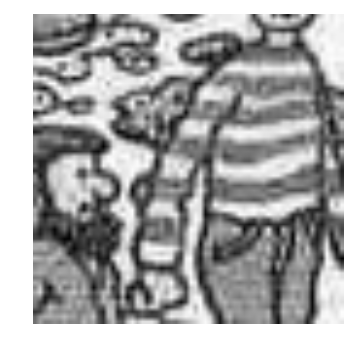

In [4]:
print('Random Waldo:')
plt.figure()
plt.axis('off')
rand = np.random.randint(0, len(iswaldos))
ax = plt.imshow(iswaldos[rand][0], cmap=plt.cm.gray)

Random not-Waldo:


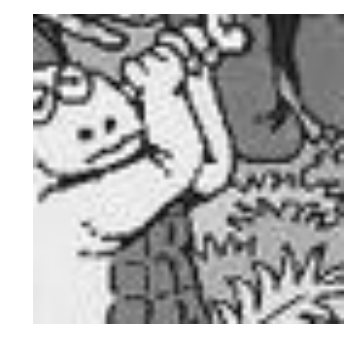

In [5]:
print('Random not-Waldo:')
plt.figure()
plt.axis('off')
rand = np.random.randint(0, len(notwaldos))
ax = plt.imshow(notwaldos[rand][0], cmap=plt.cm.gray)

In [6]:
pixels_are_cols = np.zeros(shape=(len(waldos), len(waldos[0][1])))
for i in range(len(waldos)):
    cur_pic = waldos[i][1]
    for j in range(len(waldos[0][1])):
        pixels_are_cols[i][j] = cur_pic[j]

In [30]:
# Principal Components Analysis
x = pixels_are_cols
y = waldos_df[2]
n_comps = 300

pca = PCA(n_components=n_comps)
X_pca = pca.fit(x)

/home/conrad/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


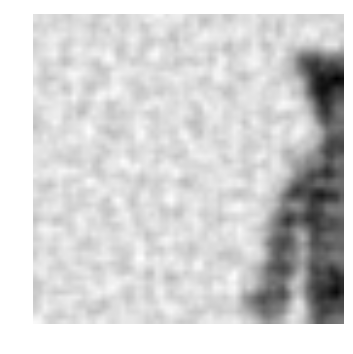

In [43]:
eigenpics = pca.components_.reshape((n_comps, 64, 64))
recd = pca.inverse_transform(pca.transform(x[6]))
plt.axis('off')
ax = plt.imshow(recd.reshape((64,64)), cmap=plt.cm.gray)